Reference
https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install nltk

In [ ]:
# !pip install texthero

In [ ]:
# !pip install catboost

In [ ]:
import os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
# nltk.download('stopwords')
stop=set(stopwords.words('english'))

import re
#from nltk.tokenize import word_tokenize
import gensim
from gensim.models import Word2Vec
import string

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import time

import hashlib

import texthero as hero
from texthero import preprocessing

import catboost as ctb
from catboost import *

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Python3/Colab Notebooks/english_python/tweets.csv')


In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
df.content = df.content.apply(lambda x : remove_URL(x))

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df.content = df.content.apply(lambda x : remove_html(x))

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df.content = df.content.apply(lambda x: remove_emoji(x))

In [ ]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df.content = df.content.apply(lambda x : remove_punct(x))

In [ ]:
def create_corpus(df,target="katyperry"):
    corpus=[]
    
    for x in df[df.author==f"{target}"].content.str.split():
        for i in x:
            corpus.append(i)
    return corpus

34227
['Is', 'history', 'repeating', 'itselfDONTNORMALIZEHATE', 'barackobama', 'Thank', 'you', 'for', 'your', 'incredible']


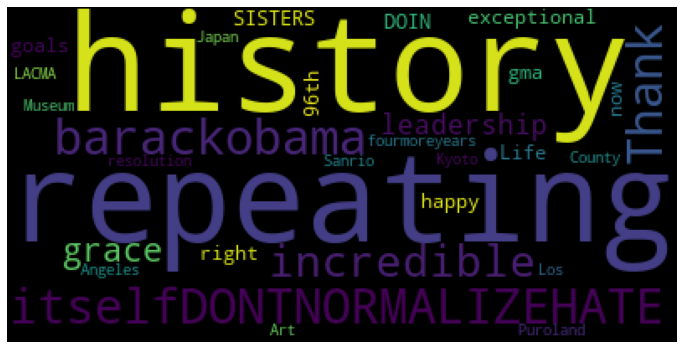

In [ ]:
corpus_new_katyperry=create_corpus(df,"katyperry")
print(len(corpus_new_katyperry))
print(corpus_new_katyperry[:10])
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new_katyperry[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

13059
['My', 'I', 'love', 'you', 'face', '10yearsofkidrauhl', 'where', 'it', 'all', 'began']


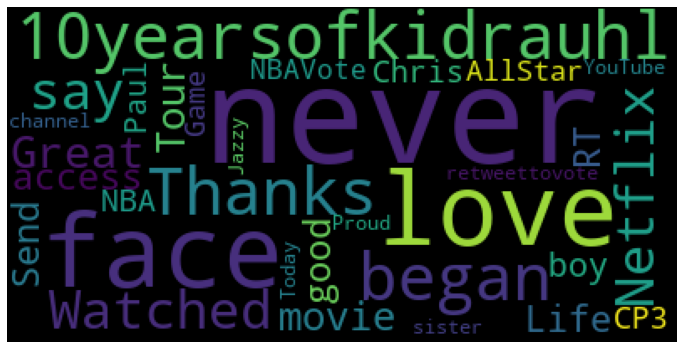

In [ ]:
corpus_new_justinbieber=create_corpus(df,"justinbieber")
print(len(corpus_new_justinbieber))
print(corpus_new_justinbieber[:10])
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new_justinbieber[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
#Enter the word Nan in the blank
df["content"].replace(" ","Nan",inplace=True)
df

,author,content,country,date_time,id,language,latitude,longitude,number_of_likes,number_of_shares
0,katyperry,Is history repeating itselfDONTNORMALIZEHATE,NaN,12/01/2017 19:52,8.196330e+17,en,NaN,NaN,7900,3472
1,katyperry,barackobama Thank you for your incredible grac...,NaN,11/01/2017 08:38,8.191010e+17,en,NaN,NaN,3689,1380
2,katyperry,Life goals,NaN,11/01/2017 02:52,8.190140e+17,en,NaN,NaN,10341,2387
3,katyperry,Me right now,NaN,11/01/2017 02:44,8.190120e+17,en,NaN,NaN,10774,2458
4,katyperry,SISTERS ARE DOIN IT FOR THEMSELVES,NaN,10/01/2017 05:22,8.186890e+17,en,NaN,NaN,17620,4655
...,...,...,...,...,...,...,...,...,...,...
52537,ddlovato,Life couldnt be better right now,NaN,06/01/2015 23:10,5.526030e+17,en,NaN,NaN,32799,23796
52538,ddlovato,First Monday back in action Id say 216 miles i...,NaN,06/01/2015 02:17,5.522880e+17,en,NaN,NaN,21709,12511
52539,ddlovato,Crime shows buddy snuggles the perfect Sunday...,NaN,05/01/2015 03:42,5.519470e+17,en,NaN,NaN,25269,15583
52540,ddlovato,Nan,NaN,05/01/2015 00:06,5.518920e+17,und,NaN,NaN,15985,10456


In [ ]:
#Vectorization
vec_tfidf = TfidfVectorizer(min_df=20)
abstract_tfidf = vec_tfidf.fit_transform(df.content.values)

In [ ]:
start = time.time()

sentences = []
print("Parsing sentences from training set ...")

#Loop over each article.
for review in tqdm(df.content):
  try:
    #split a review into parsed sentence
    result = review
    h = result.split(" ")
    h = list(filter(("").__ne__,h))
    sentences.append(h)
  except:
    continue

num_features = 200
min_word_count = 20
num_workers = 1
context = 10
downsampling = 1e-3
seed = 2022

hashfxn = lambda x: int(hashlib.md5(str(x).encode()).hexdigest(),16)

print("Training Word2Vec model...")
#Train Word2Vec model
model = Word2Vec(sentences,workers=num_workers,hs=0,sg=1,negative=10,iter=5,size=num_features,min_count=min_word_count,hashfxn=hashfxn,window=context,sample=downsampling,seed=seed)
model_name = str(num_features) + "features_" + str(min_word_count) + "minwords_" + str(context) + "context_len2alldata"
model.init_sims(replace=True)
endmodeltime = time.time()

print("time: ",endmodeltime-start)

Parsing sentences from training set ...


100%|██████████| 52542/52542 [00:00<00:00, 125330.99it/s]


Training Word2Vec model...
time:  50.36567664146423


In [ ]:
tqdm.pandas()

def des_to_mean_vec(text):
  try:
    text = text.strip()
    text_ls = [s for s in text.split(' ') if '' != s]
    return np.mean([model.wv[word] for word in text_ls if word in model.wv.index2word],axis=0)
  except:
    return np.nan

word2vec_df = df.content.progress_apply(lambda x: des_to_mean_vec(x))
word2vec_df.head()

100%|██████████| 52542/52542 [00:21<00:00, 2464.02it/s]


0    [-0.037302323, -0.058959063, 0.014117177, -0.0...
1    [0.019113978, -0.061213154, -0.008818905, -0.0...
2    [-0.0018740911, -0.060316347, -0.024763322, -0...
3    [-0.027483463, -0.04293849, -0.028281277, -0.0...
4    [0.024895148, 0.017154373, -0.003021559, -8.50...
Name: content, dtype: object

Justinbieber

In [ ]:
content_df_justinbieber = pd.DataFrame()
for num in tqdm(list(range(0,68000,1000))):
  content_df_justinbieber = pd.concat([content_df_justinbieber,word2vec_df.iloc[num:num+1000].apply(pd.Series)])
content_df_justinbieber.columns = ['w2v_content_' + str(col) for col in content_df_justinbieber.columns]
content_df_justinbieber.head()

100%|██████████| 68/68 [00:11<00:00,  6.18it/s]


,w2v_content_0,w2v_content_1,w2v_content_2,w2v_content_3,w2v_content_4,w2v_content_5,w2v_content_6,w2v_content_7,w2v_content_8,w2v_content_9,...,w2v_content_190,w2v_content_191,w2v_content_192,w2v_content_193,w2v_content_194,w2v_content_195,w2v_content_196,w2v_content_197,w2v_content_198,w2v_content_199
0,-0.037302,-0.058959,0.014117,-0.090011,-0.007072,0.055448,0.097038,-0.041137,-0.012586,-0.096235,...,-0.043358,0.004904,-0.021615,-0.022413,0.036620,0.019018,-0.041913,-0.061185,0.009255,0.023942
1,0.019114,-0.061213,-0.008819,-0.039185,0.042564,0.045340,0.080944,0.022669,-0.009640,-0.065593,...,-0.064947,-0.001366,0.023246,-0.034184,0.019603,-0.009582,-0.072600,-0.007886,0.042576,0.038451
2,-0.001874,-0.060316,-0.024763,-0.069574,-0.019425,0.060839,0.109874,-0.065317,0.057494,-0.060560,...,-0.075969,0.036438,0.000323,-0.058008,0.041354,0.056790,-0.046139,-0.056291,0.061038,-0.027712
3,-0.027483,-0.042938,-0.028281,-0.039182,0.006231,0.163340,0.051065,0.022851,-0.032212,-0.028004,...,-0.032799,-0.012980,0.005960,0.012686,0.008137,-0.018625,-0.055399,-0.022395,0.002501,0.030412
4,0.024895,0.017154,-0.003022,-0.000085,0.098488,0.054853,0.174883,0.092080,-0.013036,-0.013738,...,-0.096934,0.079894,-0.022354,0.039376,-0.033663,-0.005760,-0.093164,0.054399,0.126872,0.051378


In [ ]:
content_df_justinbieber["author"] = df.author
content_df_justinbieber["id"] = df.id
content_df_justinbieber

,w2v_content_0,w2v_content_1,w2v_content_2,w2v_content_3,w2v_content_4,w2v_content_5,w2v_content_6,w2v_content_7,w2v_content_8,w2v_content_9,...,w2v_content_192,w2v_content_193,w2v_content_194,w2v_content_195,w2v_content_196,w2v_content_197,w2v_content_198,w2v_content_199,author,id
0,-0.037302,-0.058959,0.014117,-0.090011,-0.007072,0.055448,0.097038,-0.041137,-0.012586,-0.096235,...,-0.021615,-0.022413,0.036620,0.019018,-0.041913,-0.061185,0.009255,0.023942,katyperry,8.196330e+17
1,0.019114,-0.061213,-0.008819,-0.039185,0.042564,0.045340,0.080944,0.022669,-0.009640,-0.065593,...,0.023246,-0.034184,0.019603,-0.009582,-0.072600,-0.007886,0.042576,0.038451,katyperry,8.191010e+17
2,-0.001874,-0.060316,-0.024763,-0.069574,-0.019425,0.060839,0.109874,-0.065317,0.057494,-0.060560,...,0.000323,-0.058008,0.041354,0.056790,-0.046139,-0.056291,0.061038,-0.027712,katyperry,8.190140e+17
3,-0.027483,-0.042938,-0.028281,-0.039182,0.006231,0.163340,0.051065,0.022851,-0.032212,-0.028004,...,0.005960,0.012686,0.008137,-0.018625,-0.055399,-0.022395,0.002501,0.030412,katyperry,8.190120e+17
4,0.024895,0.017154,-0.003022,-0.000085,0.098488,0.054853,0.174883,0.092080,-0.013036,-0.013738,...,-0.022354,0.039376,-0.033663,-0.005760,-0.093164,0.054399,0.126872,0.051378,katyperry,8.186890e+17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52537,-0.029745,-0.017240,0.012913,-0.035070,-0.032332,0.118437,0.067618,-0.022347,0.030064,-0.052226,...,-0.007065,-0.012944,0.016840,-0.009836,-0.066887,-0.055586,0.028116,0.014650,ddlovato,5.526030e+17
52538,0.012130,-0.074094,-0.046701,-0.044685,-0.010534,0.067790,0.069306,0.005751,-0.022866,-0.038644,...,0.002647,0.015767,0.029449,-0.009241,-0.094786,-0.015474,0.027703,0.043324,ddlovato,5.522880e+17
52539,-0.010394,-0.122918,-0.032945,-0.021268,0.001458,0.157606,0.066427,0.032274,-0.044921,-0.038207,...,-0.012028,-0.022922,-0.024582,-0.032657,-0.055255,0.008558,0.003067,0.033569,ddlovato,5.519470e+17
52540,0.088863,-0.112162,-0.062047,0.014091,0.094997,-0.082640,0.037469,-0.065528,-0.045944,0.032205,...,0.048644,0.013671,-0.084133,0.025125,0.113789,0.082618,-0.076022,0.097003,ddlovato,5.518920e+17


In [ ]:
#Divided into train data and test data
content_df = content_df_justinbieber.loc[(content_df_justinbieber.author=="justinbieber")].reset_index(drop=True)
test_justinbieber = content_df.sample(frac=0.1,random_state=2022).reset_index(drop=True)
train_justinbieber = content_df.drop(test_justinbieber.index).reset_index(drop=True)
print(train_justinbieber.shape[0])
print(test_justinbieber.shape[0])
print(content_df_justinbieber.shape[0])

1800
200
52542


In [ ]:
#Duplicate confirmation
train_justinbieber = train_justinbieber[~train_justinbieber.isin(test_justinbieber)]
print(len(train_justinbieber))

1800


In [ ]:
for cat in ["author"]:
  le = LabelEncoder()
  train_justinbieber[cat] = le.fit_transform(train_justinbieber[cat])
  test_justinbieber[cat] = le.transform(test_justinbieber[cat])

preds = test_justinbieber[["id","author"]]
train_justinbieber.drop("id",axis=1,inplace=True)
test_justinbieber.drop("id",axis=1,inplace=True)
y = train_justinbieber.pop("author")
true_y = test_justinbieber.pop("author")

Katyperry

In [ ]:
content_df_katyperry = pd.DataFrame()
for num in tqdm(list(range(0,68000,1000))):
  content_df_katyperry = pd.concat([content_df_katyperry,word2vec_df.iloc[num:num+1000].apply(pd.Series)])
content_df_katyperry.columns = ['w2v_content_' + str(col) for col in content_df_katyperry.columns]
content_df_katyperry.head()

100%|██████████| 68/68 [00:11<00:00,  6.15it/s]


,w2v_content_0,w2v_content_1,w2v_content_2,w2v_content_3,w2v_content_4,w2v_content_5,w2v_content_6,w2v_content_7,w2v_content_8,w2v_content_9,...,w2v_content_190,w2v_content_191,w2v_content_192,w2v_content_193,w2v_content_194,w2v_content_195,w2v_content_196,w2v_content_197,w2v_content_198,w2v_content_199
0,-0.037302,-0.058959,0.014117,-0.090011,-0.007072,0.055448,0.097038,-0.041137,-0.012586,-0.096235,...,-0.043358,0.004904,-0.021615,-0.022413,0.036620,0.019018,-0.041913,-0.061185,0.009255,0.023942
1,0.019114,-0.061213,-0.008819,-0.039185,0.042564,0.045340,0.080944,0.022669,-0.009640,-0.065593,...,-0.064947,-0.001366,0.023246,-0.034184,0.019603,-0.009582,-0.072600,-0.007886,0.042576,0.038451
2,-0.001874,-0.060316,-0.024763,-0.069574,-0.019425,0.060839,0.109874,-0.065317,0.057494,-0.060560,...,-0.075969,0.036438,0.000323,-0.058008,0.041354,0.056790,-0.046139,-0.056291,0.061038,-0.027712
3,-0.027483,-0.042938,-0.028281,-0.039182,0.006231,0.163340,0.051065,0.022851,-0.032212,-0.028004,...,-0.032799,-0.012980,0.005960,0.012686,0.008137,-0.018625,-0.055399,-0.022395,0.002501,0.030412
4,0.024895,0.017154,-0.003022,-0.000085,0.098488,0.054853,0.174883,0.092080,-0.013036,-0.013738,...,-0.096934,0.079894,-0.022354,0.039376,-0.033663,-0.005760,-0.093164,0.054399,0.126872,0.051378


In [ ]:
content_df_katyperry["author"] = df.author
content_df_katyperry["id"] = df.id
content_df_katyperry

,w2v_content_0,w2v_content_1,w2v_content_2,w2v_content_3,w2v_content_4,w2v_content_5,w2v_content_6,w2v_content_7,w2v_content_8,w2v_content_9,...,w2v_content_192,w2v_content_193,w2v_content_194,w2v_content_195,w2v_content_196,w2v_content_197,w2v_content_198,w2v_content_199,author,id
0,-0.037302,-0.058959,0.014117,-0.090011,-0.007072,0.055448,0.097038,-0.041137,-0.012586,-0.096235,...,-0.021615,-0.022413,0.036620,0.019018,-0.041913,-0.061185,0.009255,0.023942,katyperry,8.196330e+17
1,0.019114,-0.061213,-0.008819,-0.039185,0.042564,0.045340,0.080944,0.022669,-0.009640,-0.065593,...,0.023246,-0.034184,0.019603,-0.009582,-0.072600,-0.007886,0.042576,0.038451,katyperry,8.191010e+17
2,-0.001874,-0.060316,-0.024763,-0.069574,-0.019425,0.060839,0.109874,-0.065317,0.057494,-0.060560,...,0.000323,-0.058008,0.041354,0.056790,-0.046139,-0.056291,0.061038,-0.027712,katyperry,8.190140e+17
3,-0.027483,-0.042938,-0.028281,-0.039182,0.006231,0.163340,0.051065,0.022851,-0.032212,-0.028004,...,0.005960,0.012686,0.008137,-0.018625,-0.055399,-0.022395,0.002501,0.030412,katyperry,8.190120e+17
4,0.024895,0.017154,-0.003022,-0.000085,0.098488,0.054853,0.174883,0.092080,-0.013036,-0.013738,...,-0.022354,0.039376,-0.033663,-0.005760,-0.093164,0.054399,0.126872,0.051378,katyperry,8.186890e+17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52537,-0.029745,-0.017240,0.012913,-0.035070,-0.032332,0.118437,0.067618,-0.022347,0.030064,-0.052226,...,-0.007065,-0.012944,0.016840,-0.009836,-0.066887,-0.055586,0.028116,0.014650,ddlovato,5.526030e+17
52538,0.012130,-0.074094,-0.046701,-0.044685,-0.010534,0.067790,0.069306,0.005751,-0.022866,-0.038644,...,0.002647,0.015767,0.029449,-0.009241,-0.094786,-0.015474,0.027703,0.043324,ddlovato,5.522880e+17
52539,-0.010394,-0.122918,-0.032945,-0.021268,0.001458,0.157606,0.066427,0.032274,-0.044921,-0.038207,...,-0.012028,-0.022922,-0.024582,-0.032657,-0.055255,0.008558,0.003067,0.033569,ddlovato,5.519470e+17
52540,0.088863,-0.112162,-0.062047,0.014091,0.094997,-0.082640,0.037469,-0.065528,-0.045944,0.032205,...,0.048644,0.013671,-0.084133,0.025125,0.113789,0.082618,-0.076022,0.097003,ddlovato,5.518920e+17


In [ ]:
content_df_katyperry = content_df_katyperry.loc[(content_df_katyperry.author=="katyperry")].reset_index(drop=True)
test_katyperry = content_df_katyperry.sample(frac=0.1,random_state=2022).reset_index(drop=True)
train_katyperry = content_df_katyperry.drop(test_katyperry.index).reset_index(drop=True)
print(train_katyperry.shape[0])
print(test_katyperry.shape[0])
print(content_df_katyperry.shape[0])

2632
292
2924


In [ ]:
train_katyperry = train_katyperry[~train_katyperry.isin(test_katyperry)]
print(len(train_katyperry))

2632


In [ ]:
for cat in ["author"]:
  le = LabelEncoder()
  train_katyperry[cat] = le.fit_transform(train_katyperry[cat])
  test_katyperry[cat] = le.transform(test_katyperry[cat])

preds = test_katyperry[["id","author"]]
train_katyperry.drop("id",axis=1,inplace=True)
test_katyperry.drop("id",axis=1,inplace=True)
y = train_katyperry.pop("author")
true_y = test_katyperry.pop("author")